# Wine Price and Points Prediction
Boyao ZHOU, Pengfei MI, Rui SONG

## Introduction
<p> Wine is a unique commodity. The production of wine predates recorded history, as does the discovery of the healthful benefits of wine. Today, wine is an integral component of the culture of many countries, a form of entertainment in others, and a libation of choice for advocates of its health benefits. The wine market is huge. About 267 mhl of wine is produced and 242 mhl is consumed each year. The wine market is valued at USD 287.39 billion in 2016 and is expected to reach USD 402 billion by 2022, at a 5.8% CAGR during the forecast period. </p>

<p> In past generations, the definition of quality was the preserve of the wine producer. But with the globalization and the accompanying rapid worldwide access to information, the control of the definition of quality has thus shifted to the consumer. The intrinsic sensory aspect of wine taste and aroma are one component in the modern consumer definition of quality. Besides, consumers expect wines to be healthful and produced in an environmentally sustainable manner. </p>

<p> In contrast to other types of crops, grapes can be grown in diverse climates and soils. Although scientifically still unproven, environmental stress is believed to improve the sensory characteristics of grapes and wine, resulting in a better product. Thus, in contrast to other agricultural commodities, wine is marketed by the geographical location of production, and quality is associated with minimal vineyard inputs or manipulation. Consumers expect wine from a particular region to possess unique qualities that differentiate it from other wines of the same varietal from other regions. </p>

<p> In this context, the goal of this project is to  indentify the wine by using the description of the sommelier and some category features. We want to apply text mining and word embedding techniques into this project. In addition, we will extract some longitutde and latitude information from external source to improve our model. In the end, we want to give a more reasonable "point" and "price" based on the experimental description and the scientific indicator for the new wine of this year. The predictions will be used as decision support of an online wine store such that the price and rating this store gives will match the consumers' expectations and further experiences. </p>

## The data
<p> Our raw data is collected from Kaggle's competition <a href="https://www.kaggle.com/zynicide/wine-reviews">"Wine reviews"</a>, which was originally scrapted from <a href="http://www.winemag.com/?s=&drink_type=wine">WineEnthusiast</a>. Then, we use the following data cleaning steps to obtain our final train and test data set save in files train.csv and test.csv </p>

### Raw data

The original data set contains of 13 fields:

    *Points: the number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
    *Title: the title of the wine review, which often contains the vintage if you're interested in extracting that feature
    *Variety: the type of grapes used to make the wine (ie Pinot Noir)
    *Description: a few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
    *Country: the country that the wine is from
    *Province: the province or state that the wine is from
    *Region 1: the wine growing area in a province or state (ie Napa)
    *Region 2: sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
    *Winery: the winery that made the wine
    *Designation: the vineyard within the winery where the grapes that made the wine are from
    *Price: the cost for a bottle of the wine
    *Taster Name: name of the person who tasted and reviewed the wine
    *Taster Twitter Handle: Twitter handle for the person who tasted and reviewed the wine

### Cleaning/Tidying the data

First we check the number of NaN values in each column:

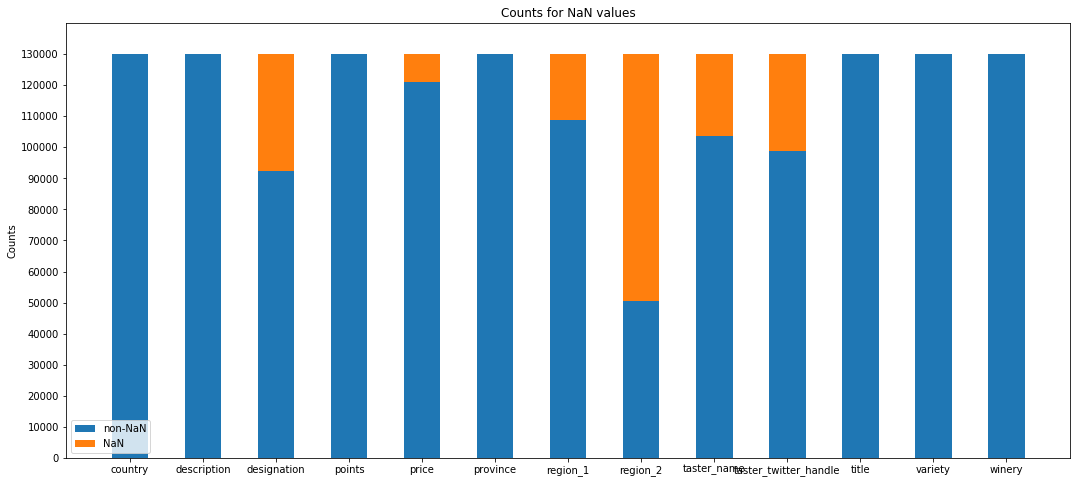

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("./data/raw_data/winemag-data-130k-v2.csv", index_col=0)

nanStats = {}
for col in list(data.columns.values):
    nanCount = data[col].isnull().sum()
    nanStats[col] = list([data[col].count(), nanCount])
    
nanStatsDF = pd.DataFrame(nanStats)

fig, ax = plt.subplots(figsize=(18, 8))

index = np.arange(13)
width = 0.5
opacity = 0.4

p1 = plt.bar(index, nanStatsDF.iloc[0,:], width)
p2 = plt.bar(index, nanStatsDF.iloc[1,:], width, bottom=nanStatsDF.iloc[0,:])

plt.ylabel('Counts')
plt.title('Counts for NaN values')
plt.ylim(0, 140000)
plt.xticks(index, list(data.columns.values))
plt.yticks(np.arange(0, 140000, 10000))
plt.legend((p1[0], p2[0]), ('non-NaN', 'NaN'))

plt.show()

So we remove the 'region_2' column, considering that over a half of this column is null value.

In addition, we drop the tuples containing null value in 'province' column.

To express the relative location of different wines, we add two columns of geographical parameters:

    *lat: latitude of 'region_1' if it can be obtained by API or 'province'
    *lng: longitude of 'region_1' if it can be obtained by API or 'province'
We use the Google Geocoding API to retrive desired data.

After these tidying steps, we randomly split the training and testing data, and save them in files "./data/train.csv" and "./data/test.csv"

## The prediction Task
<p> This task is composed of two parts: </p>
<ul>
    <li><b>Regression 1:</b> to predict the points that the reviewer gives for a particular wine.</li>
    <li><b>Regression 2:</b> to predict the price of a particular wine. </li>
</ul>
The error metric will be the root mean square error

## Exploratory data analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

## Loading the data

In [3]:
train_filename = './data/train.csv'
data = pd.read_csv(train_filename, sep=',')
#data = data.fillna('')
data.head()

,country,description,designation,points,price,province,region_1,lat,lng,taster_name,taster_twitter_handle,title,variety,winery
0,US,"Clearly a winner, a wine that shows its terroi...",Estate Vineyard,91,32.0,California,Edna Valley,35.216900,-120.607755,NaN,NaN,Alban 2000 Estate Vineyard Roussanne (Edna Val...,Roussanne,Alban
1,US,"Raw and harsh in green tannins, with bubblegum...",NaN,81,8.0,California,California,36.778261,-119.417932,NaN,NaN,Butterfield Station 2009 Merlot (California),Merlot,Butterfield Station
2,US,"Rather heavy and super-fruity now, with fruits...",NaN,87,32.0,California,Carneros,36.868516,-121.649428,NaN,NaN,Cuvaison 2007 Syrah (Carneros),Syrah,Cuvaison
3,Portugal,Assobio is from a single vineyard in the Quint...,Assobio,94,13.0,Douro,NaN,41.512019,-5.492255,Roger Voss,@vossroger,Quinta dos Murças 2011 Assobio Red (Douro),Portuguese Red,Quinta dos Murças
4,US,"This is a luscious, young Cabernet that's fill...",NaN,87,52.0,California,Calistoga,38.578797,-122.579705,NaN,NaN,Zahtila 2008 Cabernet Sauvignon (Calistoga),Cabernet Sauvignon,Zahtila


In [4]:
data.describe()

,points,price,lat,lng
count,96599.000000,96599.000000,96599.000000,96599.000000
mean,88.417302,35.421402,33.166652,-49.585733
std,3.043786,42.359112,24.140339,68.221344
min,80.000000,4.000000,-45.152671,-155.582782
25%,86.000000,17.000000,36.868516,-120.607755
50%,88.000000,25.000000,40.120875,-68.906269
75%,91.000000,42.000000,44.894387,6.739917
max,100.000000,3300.000000,56.130366,178.017649


### Countries
US dominates the wine market. Some countries such China, Slovakia, Egypt appear in the dataset but with a small volume. Once the "point" or "price" is largely impacted by the region and country, the prediction may have a great bias.

{'Peru', 'Austria', 'Germany', 'Bosnia and Herzegovina', 'Bulgaria', 'Lebanon', 'Czech Republic', 'Georgia', 'Ukraine', 'Morocco', 'Greece', 'Switzerland', 'India', 'Cyprus', 'Spain', 'Chile', 'Serbia', 'Argentina', 'Uruguay', 'England', 'Slovenia', 'Italy', 'Hungary', 'Australia', 'Macedonia', 'Canada', 'Mexico', 'Brazil', 'France', 'Moldova', 'Luxembourg', 'Portugal', 'Turkey', 'Croatia', 'Armenia', 'US', 'Israel', 'South Africa', 'New Zealand', 'Romania'}
40


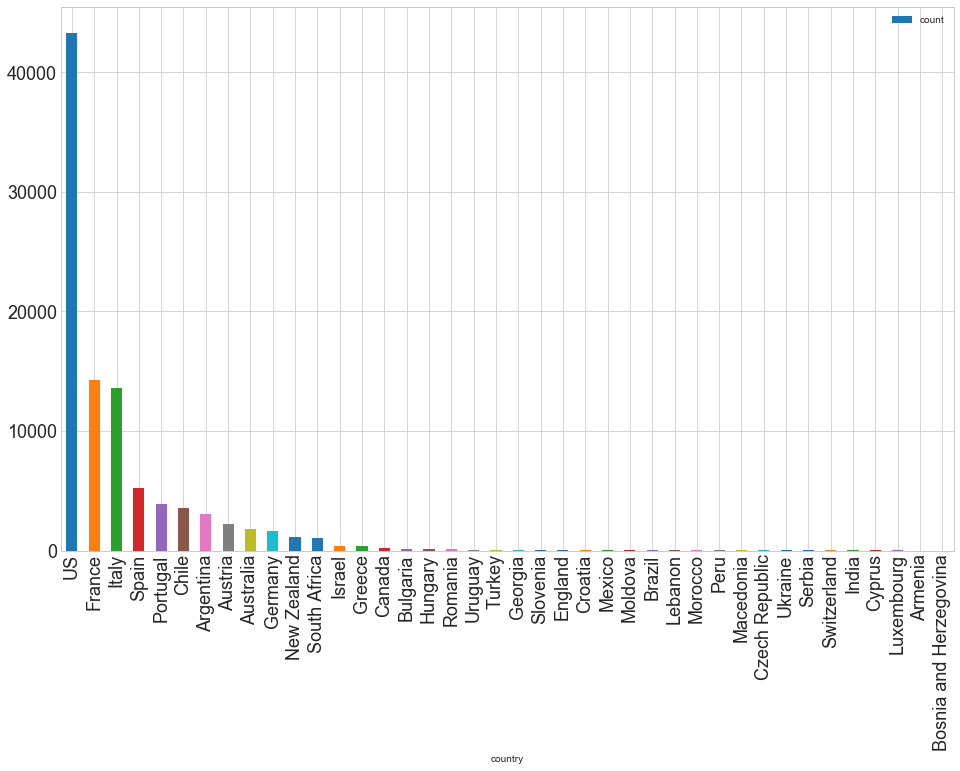

In [5]:
print(set(data['country']))
print(len(set(data['country'])))
data.groupby('country').count()[['points']].sort_values(
    'points', ascending=False).reset_index().rename(
    columns={'points': 'count'}).plot.bar(
    x='country', y='count', figsize=(16, 10), fontsize=18);

In [6]:
print(np.unique(data['winery']))
print('There are',len(np.unique(data['winery'])),'wineries.')

['1+1=3' '10 Knots' '100 Percent Wine' ..., 'Ökonomierat Rebholz'
 'àMaurice' 'Štoka']
There are 14954 wineries.


### The distribution of price
From the DataFrame info above, we see that the values of price are between 4 and 3300 USD, of which the range is very large. Now we investigate the distribution of prices in a smaller range, 0 - 200. The wines with higher value are rare case.

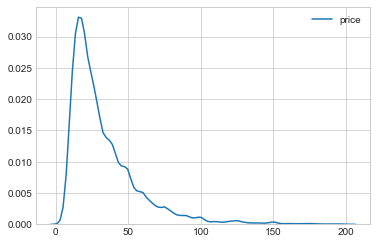

In [7]:
sns.kdeplot(data.query('price < 200').price)

And the bivariate kernel density estimate of price and points.

/usr/local/lib/python3.6/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


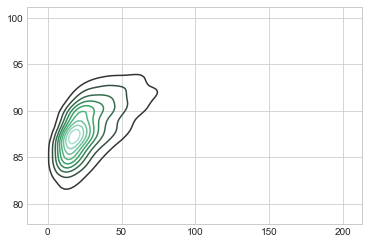

In [8]:
sns.kdeplot(data[data['price'] < 200].loc[:, ['price', 'points']].dropna().sample(5000))

Is there any correlation between points and price? We draw the scatterplot and hexplot to show the distribution of these two columns.

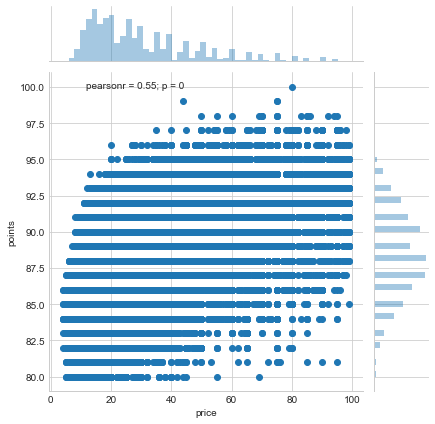

In [9]:
sns.jointplot(x='price', y='points', data=data[data['price'] < 100])

### The point distribution over countries
The "point" is bounded between 80 and 100. The more data the country contains, the more dispersive the distribution of such country is. From a technical point of view, the "point" value is more reasonable than "price" to predict since the "price" can be greatly impacted by rareness and awareness of the wine. Sometimes the wine has a extremely high price but with a normal point and we can't detect this case only by the description of the sommelier.  

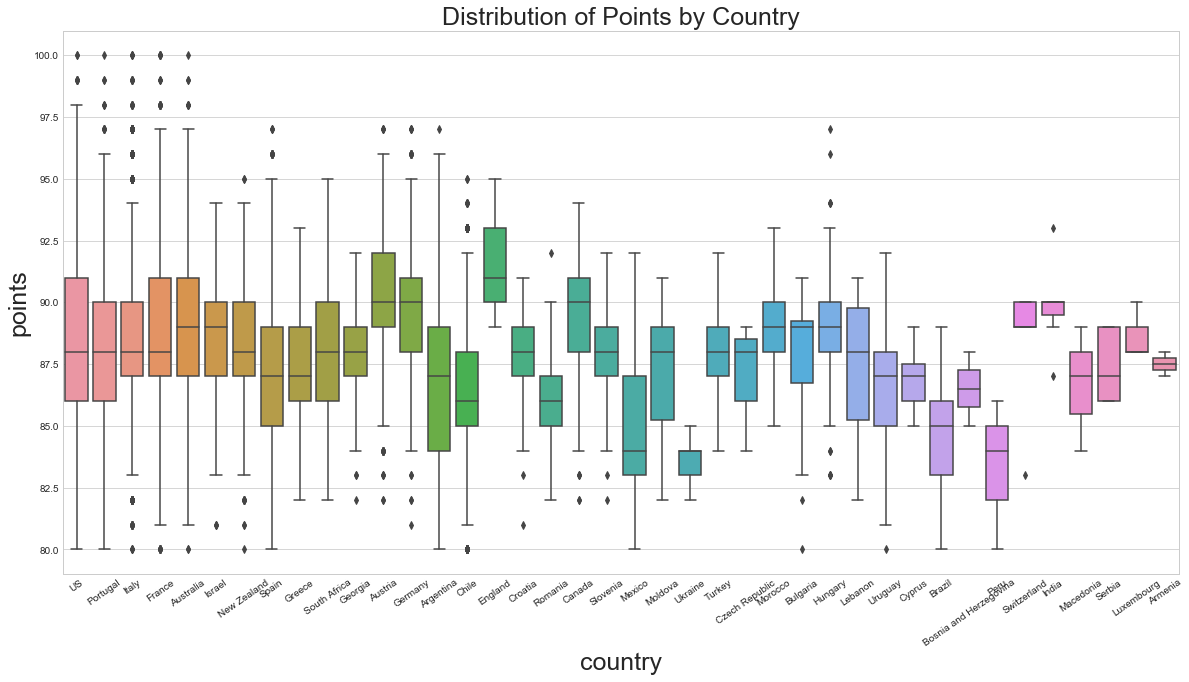

In [10]:
grouped = data.groupby('country')['points']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(x='country', y='points', data=data)
ax.set_title('Distribution of Points by Country',fontsize = 25)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 35)
ax.set_xlabel(ax.get_xlabel(), fontsize=25)
ax.set_ylabel(ax.get_ylabel(), fontsize=25);

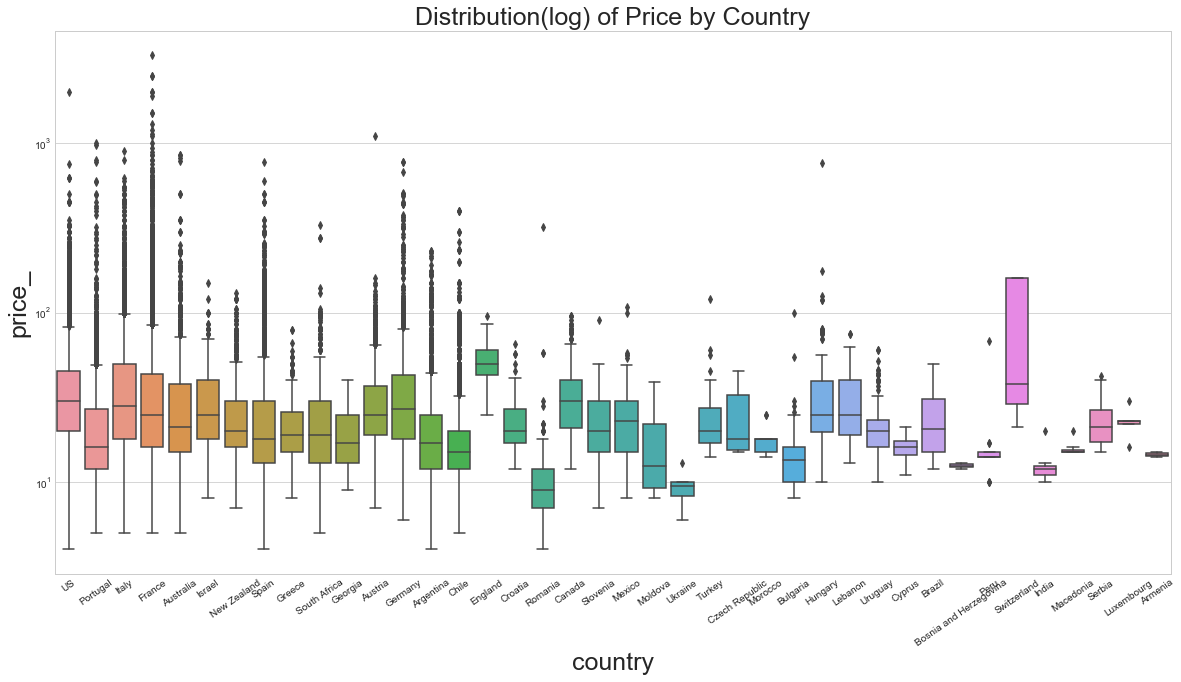

In [11]:
data_price = data[data['price'].isnull()!=True]
data_price['price_'] = data_price['price'].apply(lambda x: float(x))
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(x='country', y='price_', data=data_price)
ax.set_yscale('log', nonposy='clip')
ax.set_title('Distribution(log) of Price by Country',fontsize = 25)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 35)
ax.set_xlabel(ax.get_xlabel(), fontsize=25)
ax.set_ylabel(ax.get_ylabel(), fontsize=25);

### Top 10 values

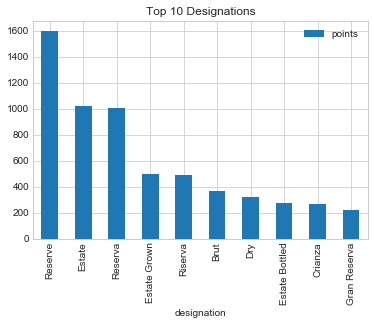

In [12]:
data.groupby('designation').count()[['points']].nlargest(10,'points').plot(title='Top 10 Designations',kind = 'bar')

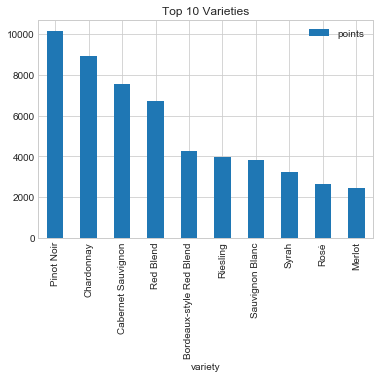

In [13]:
data.groupby('variety').count()[['points']].nlargest(10,'points').plot(title='Top 10 Varieties',kind = 'bar')

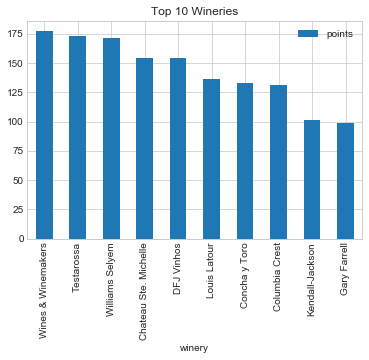

In [14]:
data.groupby('winery').count()[['points']].nlargest(10,'points').plot(title='Top 10 Wineries',kind = 'bar')

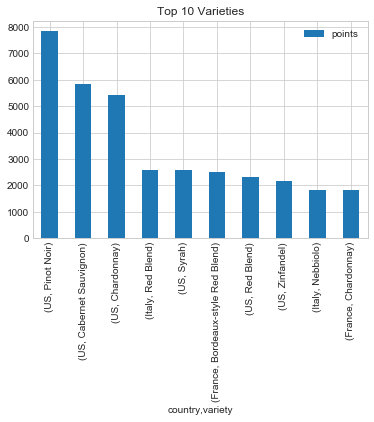

In [15]:
data.groupby(['country','variety']).count()[['points']].nlargest(10,'points').plot(title='Top 10 Varieties',kind = 'bar')

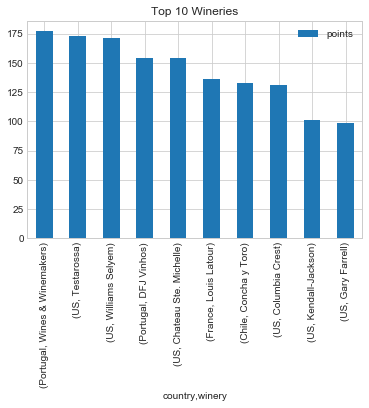

In [16]:
data.groupby(['country','winery']).count()[['points']].nlargest(10,'points').plot(title='Top 10 Wineries',kind = 'bar')

### Description aggeragation

As said before, our goal is to predict the "point" and "price" based on the description and the scientific information such as weather and location. In the following, we will first show some analysis technique to aggregate the information in the description. Indeed, the description contains the objective assessment based on fruit taste and flavor of the wine by the sommelier. Thus we want to first extract the feature of "fruit" in the description. Moreover, we find the positive and negative term from the wine tasting site(jancisrobinson). In practice, we can dummy the  fruit, positive and negative term since they are all category variables. And we apply the Sentiment Analysis package, VADER, to evaluate the sommelier's sentiment. In the end, we can extract the storage duration in the description.
- fruit term
- sentiment
- storage duration

#### Example

In [17]:
print(data['description'].loc[50767])

Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.


There are a lot of fruit term in the sentence such as pineapple, lemon, orange. "Opulent" is in the postive term while "astringent" is in the negative term. But the sentence is almost neutral, neither appreciation nor critique.  

#### Fruit term
We first want to extract the fruit term in the description, since the taste and flavor of wine are always described by fruit.

In [18]:
fruit_v =[
'apple','apricot','avocado','banana','berry',
'blackberry','blood orange','blueberry','boysenberry',
'breadfruit','cantaloupe','cherry','citron',
'citrus','coconut','crabapple','cranberry',
'current','date','dragonfruit','durian','elderberry',
'fig','grape','grapefruit','guava',
'honeydew','jackfruit','kiwi','kumquat',
'lemon','lime','lingonberry','loquat',
'lychee','mango','marionberry','melon',
'mulberry','nectarine','orange','papaya',
'passion fruit','peach','pear','persimmon',
'pineapple','plantain','plum','pluot',
'pomegranite','pomelo','prune','quince',
'raisin','raspberry','star fruit','strawberry',
'tangelo','tangerine','ugli fruit','watermelon']
def find_fruit(s):
    text = s.split(' ')
    res = []
    for i,t in enumerate(text):
        if t.lower() in fruit_v:
            res.append(t)
        else:
            pass
        
    return res 

In [19]:
tem = data['description'].apply(lambda x: find_fruit(x))
data['fruit'] = tem
tem[tem.str.len() !=0][:5]

1              [raspberry]
4     [blackberry, cherry]
5                  [apple]
10         [Citrus, berry]
13          [citrus, plum]
Name: description, dtype: object

#### Positive and negative taste and flavour term
Accoring to the wine tasting web(jancisrobinson), we construct the positive terms and negative terms proposed by the web. 

In [20]:
##tasting terms from https://www.jancisrobinson.com/learn/vocabulary/tasting-terms
pos_term = ['balanced','concentrated','crisp','firm','fresh','length','mature','powerful','rich','round','opulent']
neg_term = ['astringent','corked','dried out','flabby','green','hard','hollow','hot','lean','oxidised','short','tart','tca','volatile']
def find_pos_term(s):
    text = s.split(' ')
    res = []
    for i,t in enumerate(text):
        if t.lower() in pos_term:
            res.append(t)
        else:
            pass
        
    return res 

def find_neg_term(s):
    text = s.split(' ')
    res = []
    for i,t in enumerate(text):
        if t.lower() in neg_term:
            res.append(t)
        else:
            pass
        
    return res 

In [21]:
tem = data['description'].apply(lambda x: find_pos_term(x))
data['pos_term'] = tem
tem[tem.str.len() !=0][:5]

0               [firm]
3             [mature]
5              [crisp]
6    [balanced, crisp]
7               [rich]
Name: description, dtype: object

In [22]:
tem = data['description'].apply(lambda x: find_neg_term(x))
data['neg_term'] = tem
tem[tem.str.len() !=0][:5]

0      [hard]
1     [green]
7      [tart]
23     [hard]
38    [green]
Name: description, dtype: object

#### Sentiment Analysis based on NLTK
We will extract the sentiment rating based NLTK VADER package which can give us its sentiment metric based on positive, negative, neutral and compound point for each description. In fact, VADER analyses the sentence in the valence-base and polarity-base approach with the entiment-related vocabulary. In the following, we will show a simple example.      

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [24]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rui/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
#example of nltk sentiment analysis
sid = SentimentIntensityAnalyzer()
sentence = data['description'].loc[3]
ss = sid.polarity_scores(sentence)
for k in sorted(ss):
        print(k,ss[k])

compound 0.9118
neg 0.0
neu 0.765
pos 0.235


#### Create the sentiment based on VADER
Here we have two methods to evaluate the sentiment of the description. First it's based on the positive and negative word from professional tasting web. Sencond it's based on VADER point.

In [26]:
def sentiment(s):
    ss = sid.polarity_scores(s)
    res = []
    for k in sorted(ss):
        res.append(ss[k])
    return res

In [27]:
tem_senti = data['description'].apply(lambda x: sid.polarity_scores(x))
data['compound'] = tem_senti.apply(lambda x: x['compound'])
data['pos'] = tem_senti.apply(lambda x: x['pos'])
data['neg'] = tem_senti.apply(lambda x: x['neg'])
data['neu'] = tem_senti.apply(lambda x: x['neu'])

#### Time aggregation
In the description, we can find the information of the wine storage. It illustrates the best moment to enjoy this wine. Indeed, this information is always described as "drink from ", "from now " or "until ... you can enjoy" so that we extract this information as follows. In addition, the prodction is shown in the column "title".

In [28]:
# time aggregation
eng_pre_time = ['from','until']
import string
loww = string.ascii_lowercase[:26]
upp = string.ascii_uppercase[:26]
not_now = [['now'+t, t+'now'] for t in loww]

def find_year(s):
    text = s.split(' ')
    for t in text:
        if t.startswith('19') or t.startswith('20') and len(t)==4:
            return t
        else:
            pass
        
def find_year2(s):
    text = s.split(' ')
    res = []
    for i,t in enumerate(text):
        if (t.startswith('19') or t.startswith('20')) and (len(t)==4 or len(t)==5) and (text[i-1] in eng_pre_time):
            res.append(t)
        else:
            pass
        
    return res

def find_year4(s):
    text = s.split(' ')
    res = []
    for i,t in enumerate(text):
        if 'now' in t:
            flag = 0
            for tt in not_now:
                if tt[0] in t or tt[1] in t:
                    flag += 1
                else:
                    pass
            if flag==0:
                res.append(t)
            else:
                pass
        else:
            pass
        
    return res


def find_year3(s):
    text = s.split(' ')
    res = []
    for i,t in enumerate(text):
        if t.startswith('19') or t.startswith('20') and (len(t)==4 or len(t)==5):
            res.append(text[i-1])
            
        else:
            pass
        
    return res

In [29]:
tem = data['description'].apply(lambda x: find_year4(x))
data['drank_now'] = tem
#tem[tem.str.len() !=0]

In [30]:
tem = data['description'].apply(lambda x: find_year2(x))
data['drink_from'] = tem
#tem[tem.str.len() !=0]

In [31]:
data.head()

,country,description,designation,points,price,province,region_1,lat,lng,taster_name,...,winery,fruit,pos_term,neg_term,compound,pos,neg,neu,drank_now,drink_from
0,US,"Clearly a winner, a wine that shows its terroi...",Estate Vineyard,91,32.0,California,Edna Valley,35.216900,-120.607755,NaN,...,Alban,[],[firm],[hard],0.7906,0.177,0.072,0.752,[],[]
1,US,"Raw and harsh in green tannins, with bubblegum...",NaN,81,8.0,California,California,36.778261,-119.417932,NaN,...,Butterfield Station,[raspberry],[],[green],-0.4404,0.000,0.195,0.805,[],[]
2,US,"Rather heavy and super-fruity now, with fruits...",NaN,87,32.0,California,Carneros,36.868516,-121.649428,NaN,...,Cuvaison,[],[],[],-0.2455,0.061,0.086,0.853,"[now,]",[]
3,Portugal,Assobio is from a single vineyard in the Quint...,Assobio,94,13.0,Douro,NaN,41.512019,-5.492255,Roger Voss,...,Quinta dos Murças,[],[mature],[],0.9118,0.235,0.000,0.765,[],[2017.]
4,US,"This is a luscious, young Cabernet that's fill...",NaN,87,52.0,California,Calistoga,38.578797,-122.579705,NaN,...,Zahtila,"[blackberry, cherry]",[],[],0.6536,0.127,0.040,0.832,[],[]


## The Pipeline

The goal of this project is to **predict the points of each wine**, and to **predict the price of the wine**. 
Each submission will contain 2 classes, saved in 2 different files:   

* the `FeatureExtractor` in `feature_extractor.py` will be used to extract features for regression from the dataset and produce a numpy array.  
* the `Regressor` in `regressor.py` will predict the price and the points.

### Feature extractor

In [32]:
%%file submissions/starting_kit/feature_extractor.py
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

import numpy as np
import string
import unicodedata

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler

def clean_str(sentence, stem=True):
    english_stopwords = set(
        [stopword for stopword in stopwords.words('english')])
    punctuation = set(string.punctuation)
    punctuation.update(["``", "`", "..."])
    if stem:
        stemmer = SnowballStemmer('english')
        return list((filter(lambda x: x.lower() not in english_stopwords and
                            x.lower() not in punctuation,
                            [stemmer.stem(t.lower())
                             for t in word_tokenize(sentence)
                             if t.isalpha()])))

    return list((filter(lambda x: x.lower() not in english_stopwords and
                        x.lower() not in punctuation,
                        [t.lower() for t in word_tokenize(sentence)
                         if t.isalpha()])))

def strip_accents_unicode(s):
    try:
        s = unicode(s, 'utf-8')
    except NameError:
        pass
    s = unicodedata.normalize('NFD', s)
    s = s.encode('ascii', 'ignore')
    s = s.decode("utf-8")
    return str(s)

from sklearn.feature_extraction.text import TfidfVectorizer
class FeatureExtractor(TfidfVectorizer):

    def __init__(self):
        super(FeatureExtractor, self).__init__(
            input='content', encoding='utf-8',
            decode_error='strict', strip_accents=None, lowercase=True,
            preprocessor=None, tokenizer=None, analyzer='word',
            stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
            ngram_range=(1, 1), max_df=1.0, min_df=1,
            max_features=None, vocabulary=None, binary=False,
            dtype=np.int64, norm='l2', use_idf=True, smooth_idf=True,
            sublinear_tf=False)

    def fit(self, X_df, y=None):
        self._feat = np.array([' '.join(
            clean_str(strip_accents_unicode(dd)))
            for dd in X_df.description])
        super(FeatureExtractor, self).fit(self._feat)
        return self

    def fit_transform(self, X_df, y=None):
        self.fit(X_df)
        return self.transform(self.X_df)

    def transform(self, X_df):
        X = np.array([' '.join(clean_str(strip_accents_unicode(dd)))
                      for dd in X_df.description])
        check_is_fitted(self, '_feat', 'The tfidf vector is not fitted')
        X = super(FeatureExtractor, self).transform(X)
        return X

Overwriting submissions/starting_kit/feature_extractor.py


### The regressor

In [33]:
%%file submissions/starting_kit/regressor.py
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import ExtraTreesRegressor


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = make_pipeline(
            Imputer(strategy='median'),
            ExtraTreesRegressor(
                n_estimators=10, max_leaf_nodes=10, random_state=61))

    def fit(self, X, y):
        return self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

Overwriting submissions/starting_kit/regressor.py


## Local testing

In [ ]:
#!ramp_test_submission --quick-test

## References
<p><a href="https://www.nature.com/articles/nature01018"> The present and future of the international wine industry </a></p>

<p><a href="https://www.statista.com/statistics/232937/volume-of-global-wine-consumption/"> Wine consumption worldwide from 2000 to 2016 (in million hectoliters) </a></p>

<p><a href="http://www.oiv.int/public/medias/5287/oiv-noteconjmars2017-en.pdf">State of the Vitiviniculture World Market</a></p>

<p><a href="https://www.mordorintelligence.com/industry-reports/wine-market?gclid=CjwKCAiA47DTBRAUEiwA4luU2b9hyN7npi6FHY8Hk4S5F2qESRtWBvYjRtBwosPGebh26uTvWZw3wxoCjwAQAvD_BwE">Global Wine Market - Growth, Trends and Forecasts (2017-2022)</a></p>

<p> </p>
<p> </p>
<p> </p>
<p> </p>
<p> </p>